## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

## Loading Datasets

In [2]:
# Load main structured log dataset
df_struct = pd.read_csv('D:\Research Project\HDFS_2k.log_structured.csv')
df_struct.head(5)

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate
0,1,81109,203615,148,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_38865049064139...,E10,PacketResponder <*> for block blk_<*> terminating
1,2,81109,203807,222,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_-6952295868487...,E10,PacketResponder <*> for block blk_<*> terminating
2,3,81109,204005,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...,E6,BLOCK* NameSystem.addStoredBlock: blockMap upd...
3,4,81109,204015,308,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_82291938032499...,E10,PacketResponder <*> for block blk_<*> terminating
4,5,81109,204106,329,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_-6670958622368...,E10,PacketResponder <*> for block blk_<*> terminating


In [3]:
print(df_struct.columns)

Index(['LineId', 'Date', 'Time', 'Pid', 'Level', 'Component', 'Content',
       'EventId', 'EventTemplate'],
      dtype='object')


In [4]:
# Display the first few rows of Date and Time columns
print(df_struct[['Date', 'Time']].head())

    Date    Time
0  81109  203615
1  81109  203807
2  81109  204005
3  81109  204015
4  81109  204106


In [5]:
# Convert Date and Time columns to strings first
df_struct['Date'] = df_struct['Date'].astype(str).str.zfill(6)
df_struct['Time'] = df_struct['Time'].astype(str).str.zfill(6)

# Combine and convert to datetime; format: YYMMDDHHMMSS
df_struct['timestamp'] = pd.to_datetime(df_struct['Date'] + df_struct['Time'], format='%y%m%d%H%M%S', errors='coerce')

# Show output
print(df_struct[['Date', 'Time', 'timestamp']].head())

     Date    Time           timestamp
0  081109  203615 2008-11-09 20:36:15
1  081109  203807 2008-11-09 20:38:07
2  081109  204005 2008-11-09 20:40:05
3  081109  204015 2008-11-09 20:40:15
4  081109  204106 2008-11-09 20:41:06


##### .astype(str) guarantees both columns are strings and safely concatenates them.
##### errors='coerce' ensures malformed date-time combinations become NaT (not-a-time), which can be dropped or flagged.

## Data Cleaning

In [6]:
# Drop rows where timestamp couldn't be parsed
df_struct = df_struct[df_struct['timestamp'].notnull()]

In [7]:
# Handle missing values in other columns
# Fill missing Pid, Level, Component with explicit 'Missing' or mode
for col in ['Pid', 'Level', 'Component', 'Content', 'EventId', 'EventTemplate']:
    if df_struct[col].isnull().any():
        if df_struct[col].dtype == 'object':
            df_struct[col].fillna('Missing', inplace=True)
        else:
            # For non-object columns, fill with mode or a constant
            df_struct[col].fillna(df[col].mode()[0], inplace=True)

In [8]:
# Normalize log level entries (e.g., upper case and standardize common levels)
df_struct['Level'] = df_struct['Level'].str.upper()
df_struct['Level'] = df_struct['Level'].replace({'WARN': 'WARNING', 'ERR': 'ERROR'})

In [9]:
# Remove duplicate rows for cleanliness
df_struct.drop_duplicates(inplace=True)

## Saving the Cleaned dataset

In [10]:
# Sort by timestamp for windowing
df_struct.sort_values('timestamp', inplace=True)

# Save cleaned dataset for reproducibility
df_struct.to_csv('D:\Research Project\HDFS_cleaned.csv', index=False)

print("Preprocessing complete. Data saved to HDFS_cleaned.csv.")
print(df_struct.head())

Preprocessing complete. Data saved to HDFS_cleaned.csv.
   LineId    Date    Time  Pid Level                     Component  \
0       1  081109  203615  148  INFO  dfs.DataNode$PacketResponder   
1       2  081109  203807  222  INFO  dfs.DataNode$PacketResponder   
2       3  081109  204005   35  INFO              dfs.FSNamesystem   
3       4  081109  204015  308  INFO  dfs.DataNode$PacketResponder   
4       5  081109  204106  329  INFO  dfs.DataNode$PacketResponder   

                                             Content EventId  \
0  PacketResponder 1 for block blk_38865049064139...     E10   
1  PacketResponder 0 for block blk_-6952295868487...     E10   
2  BLOCK* NameSystem.addStoredBlock: blockMap upd...      E6   
3  PacketResponder 2 for block blk_82291938032499...     E10   
4  PacketResponder 2 for block blk_-6670958622368...     E10   

                                       EventTemplate           timestamp  
0  PacketResponder <*> for block blk_<*> terminating 2008-11-09

In [11]:
print(df_struct.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   LineId         2000 non-null   int64         
 1   Date           2000 non-null   object        
 2   Time           2000 non-null   object        
 3   Pid            2000 non-null   int64         
 4   Level          2000 non-null   object        
 5   Component      2000 non-null   object        
 6   Content        2000 non-null   object        
 7   EventId        2000 non-null   object        
 8   EventTemplate  2000 non-null   object        
 9   timestamp      2000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 171.9+ KB
None


## Feature Engineer

In [12]:
# Load cleaned data
df = pd.read_csv('D:\Research Project\HDFS_cleaned.csv', parse_dates=['timestamp'])

# Set your time window (e.g., 1 hour)
window = '5min'  # or '10T' for 10 minutes, '1D' for 1 day, etc.

# Set timestamp as index for resampling
df.set_index('timestamp', inplace=True)

In [13]:
level_counts = df.groupby([pd.Grouper(freq=window), 'Level']).size().unstack(fill_value=0)
event_counts = df.groupby([pd.Grouper(freq=window), 'EventId']).size().unstack(fill_value=0)
total_counts = df.resample(window).size().rename('TotalCount')
feature_matrix = pd.concat([level_counts, event_counts, total_counts], axis=1).fillna(0)

In [14]:
print(feature_matrix.head())

                     INFO  WARNING   E1  E10  E11  E12  E13  E14   E2   E3  \
timestamp                                                                    
2008-11-09 20:35:00   2.0      0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0   
2008-11-09 20:40:00   6.0      0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0   
2008-11-09 20:45:00   7.0      0.0  0.0  1.0  2.0  0.0  3.0  0.0  0.0  0.0   
2008-11-09 20:50:00   6.0      0.0  0.0  1.0  2.0  0.0  0.0  0.0  0.0  0.0   
2008-11-09 20:55:00   8.0      0.0  0.0  0.0  2.0  0.0  1.0  1.0  0.0  0.0   

                      E4   E5   E6   E7   E8   E9  TotalCount  
timestamp                                                      
2008-11-09 20:35:00  0.0  0.0  0.0  0.0  0.0  0.0           2  
2008-11-09 20:40:00  0.0  0.0  4.0  0.0  0.0  0.0           6  
2008-11-09 20:45:00  0.0  0.0  1.0  0.0  0.0  0.0           7  
2008-11-09 20:50:00  0.0  0.0  1.0  2.0  0.0  0.0           6  
2008-11-09 20:55:00  0.0  0.0  3.0  1.0  0.0  0.0           8  


In [15]:
print(feature_matrix.describe()) 

             INFO     WARNING          E1         E10         E11         E12  \
count  454.000000  454.000000  454.000000  454.000000  454.000000  454.000000   
mean     4.229075    0.176211    0.176211    0.685022    0.643172    0.004405   
std      7.845666    0.535501    0.539608    1.171741    1.116002    0.066299   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      1.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      7.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
max     89.000000    4.000000    6.000000    6.000000    6.000000    1.000000   

              E13         E14          E2          E3          E4          E5  \
count  454.000000  454.000000  454.000000  454.000000  454.000000  454.000000   
mean     0.643172    0.044053    0.002203    0.176211    0.011013    0.002203   
std      1.048697    0.2054

In [16]:
print(feature_matrix.columns)        # Lists all feature columns
print(feature_matrix.shape)          # (number of rows, number of columns)

Index(['INFO', 'WARNING', 'E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E2', 'E3',
       'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'TotalCount'],
      dtype='object')
(454, 17)


In [17]:
print(feature_matrix.dtypes)

INFO          float64
WARNING       float64
E1            float64
E10           float64
E11           float64
E12           float64
E13           float64
E14           float64
E2            float64
E3            float64
E4            float64
E5            float64
E6            float64
E7            float64
E8            float64
E9            float64
TotalCount      int64
dtype: object


In [18]:
feature_matrix = feature_matrix.reset_index()  # 'timestamp' becomes a column
feature_matrix.to_csv('D:/Research Project/HDFS_features_5min.csv', index=False)

## Loading Feature Matrix data

In [19]:
# Load feature matrix
featurematrix = pd.read_csv('D:/Research Project/HDFS_features_5min.csv')

# Identify ONLY numeric columns for normalization
numeric_cols = featurematrix.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numeric columns to be normalized:", numeric_cols)

# Initialize the scaler
scaler = StandardScaler()

# Transform only the numeric columns
featurematrix_scaled = featurematrix.copy()
featurematrix_scaled[numeric_cols] = scaler.fit_transform(featurematrix[numeric_cols])

# Save the normalized result (you can set your desired path)
featurematrix_scaled.to_csv('D:/Research Project/features_scaled.csv', index=False)

# Print first few rows for confirmation
print("Feature normalization complete. Sample normalized data:")
print(featurematrix_scaled.head())

Numeric columns to be normalized: ['INFO', 'WARNING', 'E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'TotalCount']
Feature normalization complete. Sample normalized data:
             timestamp      INFO   WARNING        E1       E10       E11  \
0  2008-11-09 20:35:00 -0.284429 -0.329422 -0.326915  1.123481 -0.576953   
1  2008-11-09 20:40:00  0.225969 -0.329422 -0.326915  1.123481 -0.576953   
2  2008-11-09 20:45:00  0.353569 -0.329422 -0.326915  0.269109  1.217135   
3  2008-11-09 20:50:00  0.225969 -0.329422 -0.326915  0.269109  1.217135   
4  2008-11-09 20:55:00  0.481168 -0.329422 -0.326915 -0.585264  1.217135   

        E12       E13       E14        E2        E3        E4        E5  \
0 -0.066519 -0.613982 -0.214669 -0.046984 -0.329422 -0.089045 -0.046984   
1 -0.066519 -0.613982 -0.214669 -0.046984 -0.329422 -0.089045 -0.046984   
2 -0.066519  2.249866 -0.214669 -0.046984 -0.329422 -0.089045 -0.046984   
3 -0.066519 -0.613982 -0.21466

## Statistical Models from Scratch

### Euclidean Distance

In [20]:
# X_orig: your original feature matrix on HDFS subset
X_orig = featurematrix[numeric_cols].values

In [21]:
mu_e = X_orig.mean(axis=0)

def euclidean_distance(x, mu):
    diff = x - mu
    return np.sqrt(np.sum(diff**2))

eucl_scores = np.array([euclidean_distance(x, mu_e) for x in X_orig])

# choose percentile guided by benchmark, e.g. 97.5th
thr_e = np.percentile(eucl_scores, 97.5)
featurematrix['Euclidean_score'] = eucl_scores
featurematrix['Euclidean_Anomaly'] = (eucl_scores > thr_e).astype(int)

### Mahalanobis Distance

In [22]:
mu_m = X_orig.mean(axis=0)
cov = np.cov(X_orig, rowvar=False)
inv_cov = np.linalg.pinv(cov)

def mahalanobis_distance(x, mu, inv_cov):
    diff = x - mu
    return np.sqrt(diff.T @ inv_cov @ diff)

mah_scores = np.array([mahalanobis_distance(x, mu_m, inv_cov) for x in X_orig])

thr_m = np.percentile(mah_scores, 97.5)
featurematrix['Mahalanobis_score'] = mah_scores
featurematrix['Mahalanobis_Anomaly'] = (mah_scores > thr_m).astype(int)

### LOF

In [23]:
n = X_orig.shape[0]
k = 20

dists = np.zeros((n, n))
for i in range(n):
    diff = X_orig - X_orig[i]
    dists[i] = np.sqrt(np.sum(diff**2, axis=1))

neighbors = np.argsort(dists, axis=1)[:, 1:k+1]
k_dist = np.array([dists[i, neighbors[i, -1]] for i in range(n)])

reach_dist = np.zeros_like(dists)
for i in range(n):
    for j in neighbors[i]:
        reach_dist[i, j] = max(k_dist[j], dists[i, j])

lrd = np.zeros(n)
for i in range(n):
    rd_sum = np.sum(reach_dist[i, neighbors[i]])
    lrd[i] = k / rd_sum if rd_sum > 0 else 0.0

lof_scores = np.zeros(n)
for i in range(n):
    if lrd[i] > 0:
        lof_scores[i] = np.sum(lrd[neighbors[i]] / lrd[i]) / k
    else:
        lof_scores[i] = np.inf

finite_lof = lof_scores[np.isfinite(lof_scores)]
thr_l = np.percentile(finite_lof, 97.5)
featurematrix['LOF_score'] = lof_scores
featurematrix['LOF_Anomaly'] = (lof_scores > thr_l).astype(int)

LOF is much more aggressive because it detects local density deviations, which leads to many more flagged anomalies.

### Gaussian log-score 

In [24]:
def gaussian_log_score(x, mu, inv_cov):
    diff = x - mu
    return -0.5 * (diff.T @ inv_cov @ diff)

gauss_scores = np.array([gaussian_log_score(x, mu_m, inv_cov) for x in X_orig])

# low log-score = anomaly → e.g. 2.5th percentile
thr_g = np.percentile(gauss_scores, 2.5)
featurematrix['Gaussian_score'] = gauss_scores
featurematrix['Gaussian_Anomaly'] = (gauss_scores < thr_g).astype(int)

In [25]:
featurematrix[['Euclidean_Anomaly',
               'Mahalanobis_Anomaly',
               'Gaussian_Anomaly',
               'LOF_Anomaly']].sum()

Euclidean_Anomaly       12
Mahalanobis_Anomaly     12
Gaussian_Anomaly        12
LOF_Anomaly            212
dtype: int64

For distance-based models, anomalies have very large scores so we use the top 97.5%, whereas LOF measures local density, so the most extreme cases appear at the opposite tail and are captured using the 2.5% cut-off.

## Visualization

| Method               | Count | Threshold |
|----------------------|-------|-----------|
| Euclidean_Anomaly    | 12    | 97.5      |
| Mahalanobis_Anomaly  | 12    | 97.5      |
| Gaussian_Anomaly     | 12    | 97.5      |
| LOF_Anomaly          | 212   | 2.5       |


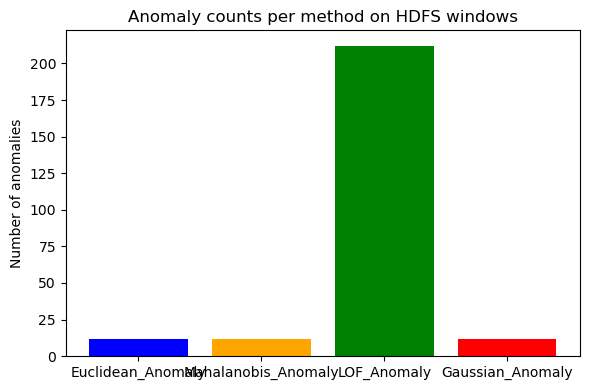

In [26]:
counts = featurematrix[['Euclidean_Anomaly',
                        'Mahalanobis_Anomaly',
                        'LOF_Anomaly',
                        'Gaussian_Anomaly']].sum()
plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values, color=['blue','orange','green','red'])
plt.ylabel('Number of anomalies')
plt.title('Anomaly counts per method on HDFS windows')
plt.tight_layout()
plt.show()

### Key Takeaway

The results highlight clear differences between global statistical models and local density-based approaches.

**Global statistical models (Euclidean, Mahalanobis, Gaussian)** behave consistently and tend to agree on which log windows are anomalous. They flag only a small number of cases, but these are typically strong, high-confidence anomalies. Because their decisions are based on clear statistical distance or probability measures, they are easier for system operators to interpret and trust.

**Local Outlier Factor (LOF)** behaves much more aggressively. By focusing on local density rather than global behaviour, it identifies many more anomalies, including subtle irregularities that global models may miss. However, this increased sensitivity also leads to a high number of false alarms, which can overwhelm operators and reduce the practical usability of LOF when used on its own.

Overall, the findings suggest that global models are better suited for reliable alerting, while LOF is more useful as a complementary method for uncovering local or emerging issues.

In [27]:
# how many windows are anomalous in at least one method
featurematrix['Any_Anomaly'] = (
    (featurematrix['Euclidean_Anomaly'] == 1) |
    (featurematrix['Mahalanobis_Anomaly'] == 1) |
    (featurematrix['Gaussian_Anomaly'] == 1) |
    (featurematrix['LOF_Anomaly'] == 1)
).astype(int)

print("Any_Anomaly:", featurematrix['Any_Anomaly'].sum())

# rows where all four agree
agree_all = featurematrix[
    (featurematrix['Euclidean_Anomaly'] == 1) &
    (featurematrix['Mahalanobis_Anomaly'] == 1) &
    (featurematrix['Gaussian_Anomaly'] == 1) &
    (featurematrix['LOF_Anomaly'] == 1)
]

print("Agree_all count:", len(agree_all))
print(agree_all[['timestamp','Euclidean_score',
                 'Mahalanobis_score','Gaussian_score',
                 'LOF_score']].head())

Any_Anomaly: 223
Agree_all count: 4
               timestamp  Euclidean_score  Mahalanobis_score  Gaussian_score  \
167  2008-11-10 10:30:00       136.966518          15.837981     -125.420818   
168  2008-11-10 10:35:00        80.795869          13.475720      -90.797517   
293  2008-11-10 21:00:00        86.891160           9.152265      -41.881981   
386  2008-11-11 04:45:00        54.771441           9.586043      -45.946112   

     LOF_score  
167  10.031678  
168   6.334853  
293   6.178439  
386   5.159622  


## Loading labelled data

In [28]:
df_bench = pd.read_csv(r'D:\Research Project\anomaly_label.csv') 
print(df_bench)
print(df_bench.columns)
print(df_bench.nunique())

                         BlockId    Label
0       blk_-1608999687919862906   Normal
1        blk_7503483334202473044   Normal
2       blk_-3544583377289625738  Anomaly
3       blk_-9073992586687739851   Normal
4        blk_7854771516489510256   Normal
...                          ...      ...
575056   blk_1019720114020043203   Normal
575057  blk_-2683116845478050414   Normal
575058   blk_5595059397348477632   Normal
575059   blk_1513937873877967730   Normal
575060  blk_-9128742458709757181  Anomaly

[575061 rows x 2 columns]
Index(['BlockId', 'Label'], dtype='object')
BlockId    575061
Label           2
dtype: int64


## HDFS data's content column vs Anomaly label's Block Id column

In [29]:
def extract_block_id(text):
    m = re.search(r'blk_[0-9\-]+', str(text))  # matches blk_ followed by digits and -
    return m.group(0) if m else None

df_struct['BlockId'] = df_struct['Content'].apply(extract_block_id)

print(df_struct[['Content', 'BlockId']].head(10))
print("Missing BlockId ratio:", df_struct['BlockId'].isna().mean())

                                             Content                   BlockId
0  PacketResponder 1 for block blk_38865049064139...     blk_38865049064139660
1  PacketResponder 0 for block blk_-6952295868487...  blk_-6952295868487656571
2  BLOCK* NameSystem.addStoredBlock: blockMap upd...   blk_7128370237687728475
3  PacketResponder 2 for block blk_82291938032499...   blk_8229193803249955061
4  PacketResponder 2 for block blk_-6670958622368...  blk_-6670958622368987959
5  BLOCK* NameSystem.addStoredBlock: blockMap upd...   blk_3050920587428079149
6  BLOCK* NameSystem.addStoredBlock: blockMap upd...   blk_7888946331804732825
7  BLOCK* NameSystem.addStoredBlock: blockMap upd...   blk_2377150260128098806
8  PacketResponder 2 for block blk_57249283928729...    blk_572492839287299681
9  Received block blk_3587508140051953248 of size...   blk_3587508140051953248
Missing BlockId ratio: 0.0


## Data Cleaning and Feature Engineering

In [30]:
print(df_bench.dtypes)
print(df_bench.isna().sum())

BlockId    object
Label      object
dtype: object
BlockId    0
Label      0
dtype: int64


In [31]:
df_struct2 = df_struct.dropna(subset=['BlockId'])

# event-count features per BlockId
counts = df_struct2.groupby(['BlockId', 'EventId']).size().unstack(fill_value=0)

# align labels
labels = df_bench.set_index('BlockId')['Label']
X_bench = counts.values
y_bench = labels.loc[counts.index].values

print(X_bench.shape, y_bench.shape)
print(pd.Series(y_bench).value_counts())

(1994, 14) (1994,)
Normal     1926
Anomaly      68
Name: count, dtype: int64


## Statistical Models from scratch and Model Evaluation

In [32]:
y = np.where(y_bench == 'Anomaly', 1, 0)

In [33]:
X_train, X_val, y_train, y_val = train_test_split(
    X_bench, y, test_size=0.3, random_state=0, stratify=y)

### Euclidean Distance

In [34]:
mu = X_train.mean(axis=0)

def euclidean_distance(x, mu):
    diff = x - mu
    return np.sqrt(np.sum(diff**2))

scores_val = np.array([euclidean_distance(x, mu) for x in X_val])

# try thresholds over a grid of percentiles
candidates = np.percentile(scores_val, np.linspace(80, 99.5, 40))

f1_eu = 0
best_thr = None

for thr in candidates:
    y_pred = (scores_val > thr).astype(int)

    TP = np.sum((y_val == 1) & (y_pred == 1))
    FP = np.sum((y_val == 0) & (y_pred == 1))
    FN = np.sum((y_val == 1) & (y_pred == 0))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    if f1 > f1_eu:
        f1_eu = f1
        best_thr = thr

print("Best Euclidean threshold:", best_thr)
print("Precision:", precision, "Recall:", recall, "F1:", f1_eu)

Best Euclidean threshold: 1.0546695930792247
Precision: 0.3333333333333333 Recall: 0.05 F1: 0.16666666666666669


### Mahalanobis Distance

In [35]:
# fit on training
mu_m = X_train.mean(axis=0)
cov = np.cov(X_train, rowvar=False)
inv_cov = np.linalg.pinv(cov)  # pseudo-inverse

def mahalanobis_distance(x, mu, inv_cov):
    diff = x - mu
    return np.sqrt(diff.T @ inv_cov @ diff)

scores_val_m = np.array([mahalanobis_distance(x, mu_m, inv_cov) for x in X_val])

candidates = np.percentile(scores_val_m, np.linspace(50, 99.5, 50))

f1_ma = 0
best_thr_m = None
best_prec = 0
best_rec = 0

for thr in candidates:
    y_pred = (scores_val_m > thr).astype(int)

    TP = np.sum((y_val == 1) & (y_pred == 1))
    FP = np.sum((y_val == 0) & (y_pred == 1))
    FN = np.sum((y_val == 1) & (y_pred == 0))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    if f1 > f1_ma:
        f1_ma, best_thr_m, best_prec, best_rec = f1, thr, precision, recall

print("Mahalanobis best thr:", best_thr_m)
print("Precision:", best_prec, "Recall:", best_rec, "F1:", f1_ma)

Mahalanobis best thr: 10.73160675353624
Precision: 0.5 Recall: 0.1 F1: 0.16666666666666669


### LOF

In [36]:
Xv = X_val
n = Xv.shape[0]
k = 20

# distance matrix
dists = np.zeros((n, n))
for i in range(n):
    diff = Xv - Xv[i]
    dists[i] = np.sqrt(np.sum(diff**2, axis=1))

neighbors = np.argsort(dists, axis=1)[:, 1:k+1]
k_dist = np.array([dists[i, neighbors[i, -1]] for i in range(n)])

reach_dist = np.zeros_like(dists)
for i in range(n):
    for j in neighbors[i]:
        reach_dist[i, j] = max(k_dist[j], dists[i, j])

lrd = np.zeros(n)
for i in range(n):
    rd_sum = np.sum(reach_dist[i, neighbors[i]])
    lrd[i] = k / rd_sum if rd_sum > 0 else 0.0

lof_val = np.zeros(n)
for i in range(n):
    if lrd[i] > 0:
        lof_val[i] = np.sum(lrd[neighbors[i]] / lrd[i]) / k
    else:
        lof_val[i] = np.inf                               

In [37]:
finite_scores = lof_val[np.isfinite(lof_val)]
candidates = np.percentile(finite_scores, np.linspace(80, 99.5, 40))

f1_lof = 0
best_thr_l = None
best_prec = 0
best_rec = 0

for thr in candidates:
    y_pred = (lof_val > thr).astype(int)  # high LOF = anomaly

    TP = np.sum((y_val == 1) & (y_pred == 1))
    FP = np.sum((y_val == 0) & (y_pred == 1))
    FN = np.sum((y_val == 1) & (y_pred == 0))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    if f1 > f1_lof:
        best_f1, best_thr_l, best_prec, best_rec = f1, thr, precision, recall

print("LOF best thr:", best_thr_l)
print("Precision:", best_prec, "Recall:", best_rec, "F1:", f1_lof)

LOF best thr: 0.85
Precision: 0.029876977152899824 Recall: 0.85 F1: 0


### Guassian

In [38]:
# reuse mu_m and inv_cov from above

def gaussian_log_score(x, mu, inv_cov):
    diff = x - mu
    return -0.5 * (diff.T @ inv_cov @ diff)  # higher = more normal, lower = more anomalous

scores_val_g = np.array([gaussian_log_score(x, mu_m, inv_cov) for x in X_val])

# candidate thresholds on log-scores (low score = anomaly)
candidates = np.percentile(scores_val_g, np.linspace(1, 50, 50))  # lower half

f1_ga = 0
best_thr_g = None
best_prec = 0
best_rec = 0

for thr in candidates:
    y_pred = (scores_val_g < thr).astype(int)  # low score → anomaly

    TP = np.sum((y_val == 1) & (y_pred == 1))
    FP = np.sum((y_val == 0) & (y_pred == 1))
    FN = np.sum((y_val == 1) & (y_pred == 0))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    if f1 > f1_ga:
        f1_ga, best_thr_g, best_prec, best_rec = f1, thr, precision, recall

print("Gaussian best thr:", best_thr_g)
print("Precision:", best_prec, "Recall:", best_rec, "F1:", f1_ga)

Gaussian best thr: -57.58369175627232
Precision: 0.5 Recall: 0.1 F1: 0.16666666666666669


## Visualization

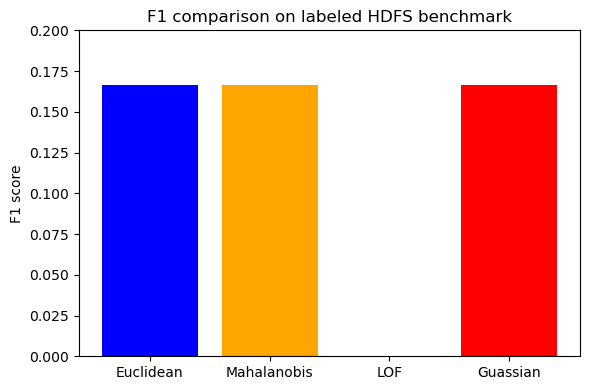

In [39]:
methods = ['Euclidean', 'Mahalanobis', 'LOF', 'Guassian']
f1_scores = [f1_eu, f1_ma, f1_lof, f1_ga]

plt.figure(figsize=(6,4))
plt.bar(methods, f1_scores, color=['blue','orange','green','red'])
plt.ylabel('F1 score')
plt.title('F1 comparison on labeled HDFS benchmark')
plt.ylim(0, max(f1_scores)*1.2)
plt.tight_layout()
plt.show()

| Method        | Best Threshold              | Precision               | Recall                  | F1 Score                 |
|---------------|-----------------------------|--------------------------|--------------------------|---------------------------|
| **Euclidean** | 1.0546695930792247          | 0.3333333333333333      | 0.05                    | 0.16666666666666669       |
| **Mahalanobis** | 10.73160675353624         | 0.5                     | 0.1                     | 0.16666666666666669       |
| **LOF**       | 0.85                        | 0.029876977152899824    | 0.85                    | 0                         |
| **Gaussian**  | -57.58369175627232          | 0.5                     | 0.1                     | 0.16666666666666669       |


## Comparing both datasets (Metrics and Anomalies) Visualization

<table>
  <tr>
    <th rowspan="2">Method</th>
    <th colspan="4">Metrics</th>
    <th colspan="2">Anomaly Stats</th>
  </tr>
  <tr>
    <th>Best Threshold</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1 Score</th>
    <th>Count</th>
    <th>Threshold (%)</th>
  </tr>

  <!-- Sorted by F1 Score descending -->
  <tr>
    <td><b>Euclidean</b></td>
    <td>1.0547</td>
    <td>0.3333</td>
    <td>0.05</td>
    <td style="background-color:#d4edda;"><b>0.1667</b></td>
    <td>12</td>
    <td>97.5</td>
  </tr>

  <tr>
    <td><b>Mahalanobis</b></td>
    <td>10.7316</td>
    <td>0.5</td>
    <td>0.1</td>
    <td style="background-color:#d4edda;"><b>0.1667</b></td>
    <td>12</td>
    <td>97.5</td>
  </tr>

  <tr>
    <td><b>Gaussian</b></td>
    <td>-57.5837</td>
    <td>0.5</td>
    <td>0.1</td>
    <td style="background-color:#d4edda;"><b>0.1667</b></td>
    <td>12</td>
    <td>97.5</td>
  </tr>

  <tr>
    <td><b>LOF</b></td>
    <td>0.85</td>
    <td>0.0299</td>
    <td>0.85</td>
    <td style="background-color:#f8d7da;"><b>0.0000</b></td>
    <td>212</td>
    <td>2.5</td>
  </tr>

</table>


### Key Insight

The evaluation results show that different anomaly detection methods make very different trade-offs between sensitivity and reliability.

**Global statistical models (Euclidean distance, Mahalanobis distance, and Gaussian likelihood)** are conservative in nature. They produce a small number of alerts, but these alerts are usually high-confidence and easy to interpret. As a result, they are less likely to overwhelm operators with false alarms. However, this cautious behaviour also means that many more subtle anomalies are missed, leading to low recall.

**Local Outlier Factor (LOF)** takes the opposite approach. It is highly sensitive to local density changes and therefore identifies a much larger number of anomalous windows. This results in high coverage and recall, but also generates a large number of false positives. In practice, this makes LOF difficult to use on its own, as the volume of alerts can quickly overwhelm system operators.

Overall, the results demonstrate that there is no single best anomaly detection model. Each method represents a different operational trade-off between precision and recall, and the most effective monitoring strategies are likely to combine multiple detectors rather than relying on a single approach.

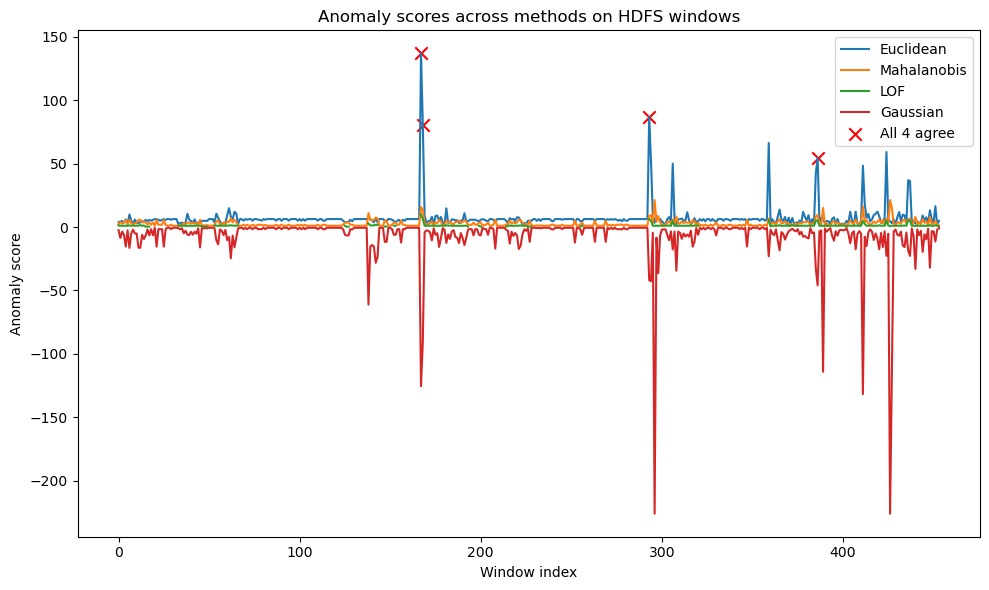

In [40]:
idx = featurematrix.index  # or a range(len(featurematrix))
eu  = featurematrix['Euclidean_score']
mah = featurematrix['Mahalanobis_score']
gau = featurematrix['LOF_score']
lof = featurematrix['Gaussian_score'] 

plt.figure(figsize=(10, 6))
plt.plot(idx, eu,  label='Euclidean')
plt.plot(idx, mah, label='Mahalanobis')
plt.plot(idx, gau, label='LOF')
plt.plot(idx, lof, label='Gaussian')

# mark windows where all four agree as anomalies
agree_all_mask = (
    (featurematrix['Euclidean_Anomaly']==1) &
    (featurematrix['Mahalanobis_Anomaly']==1) &
    (featurematrix['LOF_Anomaly']==1) &
    (featurematrix['Gaussian_Anomaly']==1) 
)
plt.scatter(idx[agree_all_mask], eu[agree_all_mask],
            color='red', marker='x', s=80, label='All 4 agree')

plt.xlabel('Window index')
plt.ylabel('Anomaly score')
plt.title('Anomaly scores across methods on HDFS windows')
plt.legend()
plt.tight_layout()
plt.show()

### Key Insights Demonstrated by the Figure

The figure illustrates how different anomaly detection methods respond to the same HDFS log windows and highlights several important insights.

**Global agreement is rare but meaningful.**  
Windows flagged as anomalous by all methods occur infrequently, but when they do, they usually correspond to severe and obvious deviations in system behaviour. These cases represent the highest-confidence anomalies and are strong candidates for further investigation.

**Different models capture different types of behaviour.**  
Global statistical models tend to produce sharp spikes in their anomaly scores, reflecting major deviations from normal system behaviour. In contrast, Local Outlier Factor (LOF) responds to more subtle, local changes in log patterns that may not appear extreme from a global perspective.

**No single model tells the full story.**  
The figure visually reinforces that relying on a single detection method is insufficient. Global models provide reliable, high-confidence alerts, while LOF offers broader coverage of local irregularities. Combining multiple detectors therefore provides a more balanced and trustworthy view of system behaviour.